In [8]:
import torch
from tqdm import tqdm

from ptn.dists import dists
from ptn.dists._abc import AbstractDisributionHeadConfig

def train_single_example_dmrg(use_scale_factors=True, iters=1000, model_name="mps_bm_dmrg"):
    losses = []
    B, R, H, D, V = 32, 8, 8, 1, 2
    mt_head = dists[model_name](
        AbstractDisributionHeadConfig(
            d_model=D,
            d_output=V,
            horizon=H,
            rank=2,
            use_scale_factors=use_scale_factors,
        ),
    )
    x = torch.randn(B, D)
    y = torch.randint(0, V, (B, H))
    for i in tqdm(range(iters), desc="Training", leave=False):
        _losses = mt_head.train_example(x, y, lr=1e-3)
        # print(f"[{i}] loss: {losses[-1]:.2f}")
        losses.append(_losses[-1])
    return losses

def train_single_example_lsf(use_scale_factors=True, iters=1000, model_name="mps_bm_lsf"):
    losses = []
    B, R, H, D, V = 32, 8, 8, 1, 2
    mt_head = dists[model_name](
        AbstractDisributionHeadConfig(
            d_model=D,
            d_output=V,
            horizon=H,
            rank=2,
            use_scale_factors=use_scale_factors,
        ),
    )
    x = torch.randn(B, D)
    y = torch.randint(0, V, (B, H))
    optimizer = torch.optim.SGD(mt_head.parameters(), lr=1e-3)
    for i in tqdm(range(iters), desc="Training", leave=False):
        optimizer.zero_grad()
        output = mt_head(x, y)
        loss = output.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
    return losses

In [9]:
mps_bm_dmrg_losses_nosf = train_single_example_dmrg(use_scale_factors=False, iters=1000)
mps_bm_dmrg_losses_sf = train_single_example_dmrg(use_scale_factors=True, iters=1000)

mps_bm_lsf_losses_nosf = train_single_example_lsf(use_scale_factors=True, iters=1000, model_name="mps_bm_lsf")
mps_bm_lsf_losses_sf = train_single_example_lsf(use_scale_factors=False, iters=1000, model_name="mps_bm_lsf")

In [10]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"loss": torch.stack(mps_bm_dmrg_losses_nosf).tolist(), "type": "nosf", "model": "mps_bm_dmrg"})
df = pd.concat([df, pd.DataFrame({"loss": torch.stack(mps_bm_dmrg_losses_sf).tolist(), "type": "sf", "model": "mps_bm_dmrg"})])
df = pd.concat([df, pd.DataFrame({"loss": torch.stack(mps_bm_lsf_losses_nosf).tolist(), "type": "nosf", "model": "mps_bm_lsf"})])
df = pd.concat([df, pd.DataFrame({"loss": torch.stack(mps_bm_lsf_losses_sf).tolist(), "type": "sf", "model": "mps_bm_lsf"})])
df 

,loss,type,model
0,1.019453,nosf,mps_bm_dmrg
1,0.993644,nosf,mps_bm_dmrg
2,0.975018,nosf,mps_bm_dmrg
3,0.960013,nosf,mps_bm_dmrg
4,0.947381,nosf,mps_bm_dmrg
...,...,...,...
995,4.079609,sf,mps_bm_lsf
996,4.079469,sf,mps_bm_lsf
997,4.079329,sf,mps_bm_lsf
998,4.079189,sf,mps_bm_lsf


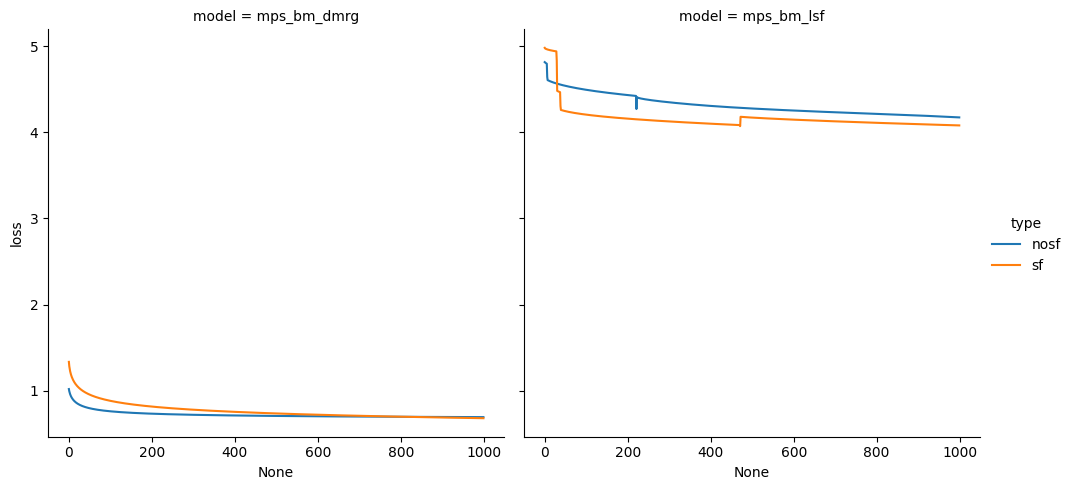

In [12]:
sns.relplot(data=df, x=df.index, y="loss", kind="line", hue="type", col="model")

In [ ]:
df